In [2]:
!pip install scikit-surprise


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering 
import matplotlib.pyplot as plt
import seaborn as sns

# 1 - Business Problem
Recommend a best book based on the ratings

# 2 - Data collection and description

In [7]:
df=pd.read_csv('/content/book.csv',encoding='latin1')

In [8]:
df.head()

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6


In [9]:
df.rename(columns={'User.ID':'userId','Book.Title':'book_title','Book.Rating':'book_rating'})

,Unnamed: 0,userId,book_title,book_rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6
...,...,...,...,...
9995,9996,162121,American Fried: Adventures of a Happy Eater.,7
9996,9997,162121,Cannibal In Manhattan,9
9997,9998,162121,How to Flirt: A Practical Guide,7
9998,9999,162121,Twilight,8


In [10]:
df1 = df.iloc[:,1:]

In [20]:
df1.columns = ['userId','book_title','book_rating']

In [32]:
print('# of records: %d\n# of books: %d\n# of users: %d' % (len(df1), len(df1['book_title'].unique()), len(df1['userId'].unique())))

# of records: 10000
# of books: 9659
# of users: 2182


In [22]:
palette = sns.color_palette("RdBu", 10)


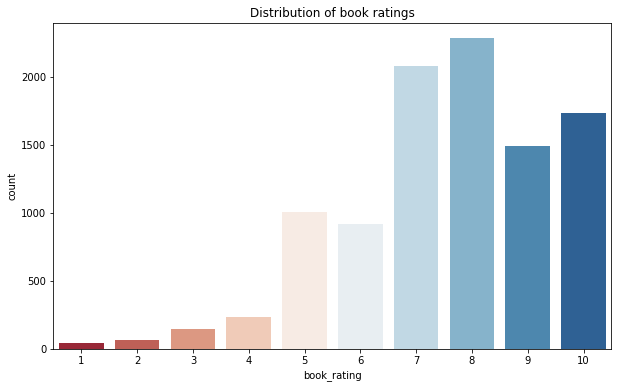

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='book_rating', data=df1, palette=palette)
ax.set_title('Distribution of book ratings')
plt.show()

The majority of ratings is between 5 and 10. Most often users tend to rate books for 8. Second the most frequent score is 7.

# 3 - Introduction to surprise Package

In [24]:
df1.book_rating.unique()

array([ 5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [25]:
import surprise
reader = surprise.Reader(rating_scale=(1, 10))

In [27]:
data = surprise.Dataset.load_from_df(df1[['userId', 'book_title', 'book_rating']], reader)

In [28]:
trainset, testset = train_test_split(data, test_size=.20)

# 4 - Finding the best algorithm for our Recommendation System

In [29]:
benchmark=[]

In [33]:
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [34]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.686352,4.584030,0.033657
SVD,1.689809,0.553905,0.051281
BaselineOnly,1.704249,0.035764,0.026311
KNNBaseline,1.707677,0.109731,0.060742
KNNWithMeans,1.817998,0.108780,0.026392
SlopeOne,1.819821,1.557843,0.033006
KNNBasic,1.822704,0.075672,0.028214
CoClustering,1.859199,0.919248,0.019535
NMF,1.893587,1.097118,0.025756


SVD () algorithm gave us the best rmse, therefore, we will train and predict with SVD

# 5 - Building our Recommendation System using surprise

In [35]:
algo= SVD()

In [36]:
algo.fit(trainset)

In [37]:
predictions= algo.test(testset)

In [43]:
surprise.accuracy.rmse(predictions,verbose=True)

RMSE: 1.7014


1.7013968714826755

In [83]:
def recommendation(userId):
    user = df1.copy()
    already_read = df1[df1['userId'] == userId]['book_title'].unique()
    user = user.reset_index()
    user = user[~user['book_title'].isin(already_read)]
    user['Estimate_Score']=user['book_title'].apply(lambda x: algo.predict(userId, x).est)
    #user = user.drop('title', axis = 1)
    user = user.sort_values('Estimate_Score', ascending=False)
    print(user.head(15))

# 6 - Building our Recommendation System using correlation

In [58]:
rating = pd.pivot_table(df1, index='userId', values='book_rating', columns='book_title', fill_value=0)

In [72]:
corr=np.corrcoef(rating.T)

In [62]:
book_list=  list(rating)

In [63]:
titles=[]

In [64]:
for i in range(len(book_list)):
    titles.append(book_list[i])


In [65]:
titles

[' Jason, Madison &amp',
 ' Other Stories;Merril;1985;McClelland &amp',
 ' Repairing PC Drives &amp',
 "'48",
 "'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR',
 '01-01-00: A Novel of the Millennium',
 '1,401 More Things That P*Ss Me Off',
 '10 Commandments Of Dating',
 '100 Great Fantasy Short, Short Stories',
 '1001 Brilliant Ways to Checkmate',
 '101 Bright Ideas: Esl Activities for All Ages',
 '101 Dalmatians',
 '101 Essential Tips: House Plants',
 '101 Telephone Jokes',
 '101 Wacky Computer Jokes',
 '101 Ways to Make Money at Home',
 '11 Edward Street',
 '11th Hour',
 '13 99 Euros',
 '14,000 Things to Be Happy About',
 '1984',
 '1st to Die: A Novel',
 '20 Jahre 40 bleiben. Jung und schÃ?Â¶n in den besten Jahren.',
 '20 Years of Censored News',
 '20,000 Leagues Under the Sea (Wordsworth Collection)',
 '20,001 Names for Baby',
 '2001 Spanish and English Idioms/2001 Modismos Espanoles E Ingleses: 

In [73]:
def get_recommendation(books_list):
    book_similarities = np.zeros(corr.shape[0])
    
    for book in books_list:
        book_index = titles.index(book)
        book_similarities += corr[book_index] 
        book_preferences = []
    for i in range(len(titles)):
        book_preferences.append((titles[i],book_similarities[i]))
        
    return sorted(book_preferences, key= lambda x: x[1], reverse=True)

# 7 - Conclusion

In [84]:
recommendation(276747)

      index  userId                                         book_title  \
1722   1722  278202                Something Under the Bed Is Drooling   
851     851  277471                    No Shirt, No Shoes, No Problem!   
2419   2419      26                                         The Jester   
1276   1276  277928  Der kleine Taschentherapeut. In 60 Sekunden wi...   
1319   1319  277938                              Elfstones of Shannara   
9689   9689  162014          Cadaveres Exquisitos (Biblioteca del sur)   
2769   2769     382                                        Three Fates   
8138   8138    4157  The Thru-hiker's Handbook (Georgia to Maine 20...   
254     254  276929                                        Night Watch   
6866   6866    3599  Isabel: Jewel of Castilla, Spain, 1466 (The Ro...   
4554   4554    1928      Maitland Maternity Christmas: (3 Novels in 1)   
3892   3892    1296     The Lottery Winner : Alvirah And Willy Stories   
9412   9412  161870                   

You can enter any User ID and get the recommendation and estimated score

In [88]:
my_fav_books = ['Ashes to Ashes','Black Fire']

In [89]:
print('The books you might like: \n' , get_recommendation(my_fav_books)[:10])

The books you might like: 
 [('A Delusion of Satan: The Full Story of the Salem Witch Trials', 0.9995414947271893), ('A Sorrow in Our Heart: The Life of Tecumseh', 0.9995414947271893), ("Arrow's Fall", 0.9995414947271893), ("Arrow's Flight (Heralds of Valdemar)", 0.9995414947271893), ('Arrows of the Queen (Heralds of Valdemar)', 0.9995414947271893), ('Ashes to Ashes', 0.9995414947271893), ('Crime Scene: The Ultimate Guide to Forensic Science', 0.9995414947271893), ('Crossed Swords', 0.9995414947271893), ('Daddy Again (By Request) (Harlequin by Request)', 0.9995414947271893), ('Eye of the Beholder', 0.9995414947271893)]


You can enter your favourite book and get the recommendation on what might like